In [2]:
import pandas as pd
import pypsa

# Load Data

In [8]:
# load electricity demand data
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime
country='DEU'
print(df_elec[country].head())

# load onshore wind data
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)

# load offshore wind data
df_offshorewind = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshorewind.index = pd.to_datetime(df_offshorewind.index)

# load large scale pv data
df_pv = pd.read_csv('data\pv_optimal.csv', sep=';', index_col=0)
df_pv.index = pd.to_datetime(df_pv.index)

# load rooftop pv data
df_rooftop = pd.read_csv('data\pv_rooftop.csv', sep=';', index_col=0)
df_rooftop.index = pd.to_datetime(df_rooftop.index)


<>:16: DeprecationWarning: invalid escape sequence '\p'
<>:20: DeprecationWarning: invalid escape sequence '\p'
<>:16: DeprecationWarning: invalid escape sequence '\p'
<>:20: DeprecationWarning: invalid escape sequence '\p'
C:\Users\alexk\AppData\Local\Temp\ipykernel_10936\597844512.py:16: DeprecationWarning: invalid escape sequence '\p'
  df_pv = pd.read_csv('data\pv_optimal.csv', sep=';', index_col=0)
C:\Users\alexk\AppData\Local\Temp\ipykernel_10936\597844512.py:20: DeprecationWarning: invalid escape sequence '\p'
  df_rooftop = pd.read_csv('data\pv_rooftop.csv', sep=';', index_col=0)


utc_time
2015-01-01 00:00:00+00:00    44546.0
2015-01-01 01:00:00+00:00    42967.0
2015-01-01 02:00:00+00:00    41582.0
2015-01-01 03:00:00+00:00    40964.0
2015-01-01 04:00:00+00:00    40247.0
Name: DEU, dtype: float64


# Make Network

In [5]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

In [ ]:
network = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

network.set_snapshots(hours_in_2015.values)

# add electricity bus
network.add("Bus",
            f"E_bus{country}")

# add load to the bus
network.add("Load",
            "load",
            bus=f"E_bus{country}",
            p_set=df_elec[country].values)

# add the different carriers, only gas emits CO2
network.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
network.add("Carrier", "coal", co2_emissions=0.9) # in t_CO2/MWh_th
network.add("Carrier", "onshorewind")
network.add("Carrier", "offshorewind")
network.add("Carrier", "solar")

''' Add renewable generators '''
# Add onshore wind
CF_wind_onshore = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
lifetime = 30 # years
discount_rate = 0.07 # 7%
capex = 910000 # in €/MW
fopex = 0.033 # 3.3% of capex
capital_cost_onshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
network.add("Generator",
            "onshorewind",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_onshore.values)

# Add offshore wind
CF_wind_offshore = df_offshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 2506000 # in €/MW
fopex = 0.03 # 3% of capex
capital_cost_offshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
network.add("Generator",
            "offshorewind",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="offshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_offshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_offshore.values)

# Add large scale solar
CF_solar = df_pv[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 425000 # in €/MW
fopex = 0.03 # 3% of capex
capital_cost_pv = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
network.add("Generator",
            "PV",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_pv,
            marginal_cost = 0,
            p_max_pu = CF_solar.values)

# Add rooftop solar
CF_rooftop = df_rooftop[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 725000 # in €/MW
fopex = 0.02 # 2% of capex
capital_cost_rooftop = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
network.add("Generator",
            "rooftopPV",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_rooftop,
            marginal_cost = 0,
            p_max_pu = CF_rooftop.values)

''' Add non-renewables generators '''
# add OCGT (Open Cycle Gas Turbine) generator
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 560000 # in €/MW
fopex = 0.033 # 3.3% of capex
capital_cost_OCGT = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
fuel_cost = 21.6 # in €/MWh_th
efficiency = 0.39 # MWh_elec/MWh_th
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            efficiency = efficiency,
            marginal_cost = marginal_cost_OCGT)

# add coal generator (without CCS) # https://atb-archive.nrel.gov/electricity/2018/index.html?t=cc
lifetime = 35 # years
discount_rate = 0.07 # 7%
capex = 3294000 # in €/MW
fopex = 0.03 # 3% of capex
capital_cost_coal = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
fuel_cost = 4 # in €/MWh_th 
efficiency = 0.36 # MWh_elec/MWh_th
marginal_cost_coal = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "coal",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="coal",
            #p_nom_max=1000,
            capital_cost = capital_cost_coal,
            efficiency = efficiency,
            marginal_cost = marginal_cost_coal)



Index(['coal'], dtype='object')

In [24]:
network.optimize(solver_name='gurobi')

Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 10.71it/s]
INFO:linopy.io: Writing time: 1.27s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-_oy3gpr1.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-_oy3gpr1.lp


Reading time = 0.41 seconds


INFO:gurobipy:Reading time = 0.41 seconds


obj: 113886 rows, 52566 columns, 201770 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201770 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201770 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201770 nonzeros


Model fingerprint: 0x76f680cd


INFO:gurobipy:Model fingerprint: 0x76f680cd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.18s


INFO:gurobipy:Presolve time: 0.18s


Presolved: 52844 rows, 44090 columns, 132252 nonzeros


INFO:gurobipy:Presolved: 52844 rows, 44090 columns, 132252 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.817e+04


INFO:gurobipy: AA' NZ     : 8.817e+04


 Factor NZ  : 4.649e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.649e+05 (roughly 40 MB of memory)


 Factor Ops : 4.372e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.372e+06 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.02581350e+11  0.00000000e+00  6.09e+05 0.00e+00  1.88e+08     0s


INFO:gurobipy:   0   3.02581350e+11  0.00000000e+00  6.09e+05 0.00e+00  1.88e+08     0s


   1   4.48546965e+11 -5.84535333e+11  9.72e+04 7.07e+02  5.54e+07     0s


INFO:gurobipy:   1   4.48546965e+11 -5.84535333e+11  9.72e+04 7.07e+02  5.54e+07     0s


   2   3.71784857e+11 -3.08001708e+11  1.46e-10 6.00e+00  5.44e+06     1s


INFO:gurobipy:   2   3.71784857e+11 -3.08001708e+11  1.46e-10 6.00e+00  5.44e+06     1s


   3   1.57842146e+11 -1.80419228e+10  1.16e-10 2.95e-01  1.35e+06     1s


INFO:gurobipy:   3   1.57842146e+11 -1.80419228e+10  1.16e-10 2.95e-01  1.35e+06     1s


   4   9.09264919e+10  7.80125926e+09  1.75e-10 9.63e-02  6.32e+05     1s


INFO:gurobipy:   4   9.09264919e+10  7.80125926e+09  1.75e-10 9.63e-02  6.32e+05     1s


   5   6.22034065e+10  1.22569764e+10  3.49e-10 6.23e-02  3.80e+05     1s


INFO:gurobipy:   5   6.22034065e+10  1.22569764e+10  3.49e-10 6.23e-02  3.80e+05     1s


   6   4.71828885e+10  1.59316633e+10  1.41e-08 3.42e-02  2.37e+05     1s


INFO:gurobipy:   6   4.71828885e+10  1.59316633e+10  1.41e-08 3.42e-02  2.37e+05     1s


   7   3.92872187e+10  1.93133196e+10  5.76e-09 1.26e-02  1.51e+05     1s


INFO:gurobipy:   7   3.92872187e+10  1.93133196e+10  5.76e-09 1.26e-02  1.51e+05     1s


   8   3.84938018e+10  2.00461659e+10  1.23e-08 1.10e-02  1.40e+05     1s


INFO:gurobipy:   8   3.84938018e+10  2.00461659e+10  1.23e-08 1.10e-02  1.40e+05     1s


   9   3.15291337e+10  2.08322113e+10  3.66e-07 3.87e-04  8.11e+04     1s


INFO:gurobipy:   9   3.15291337e+10  2.08322113e+10  3.66e-07 3.87e-04  8.11e+04     1s


  10   2.71240823e+10  2.17452813e+10  1.94e-07 2.01e-09  4.08e+04     1s


INFO:gurobipy:  10   2.71240823e+10  2.17452813e+10  1.94e-07 2.01e-09  4.08e+04     1s


  11   2.57882247e+10  2.23442851e+10  7.08e-08 5.11e-10  2.61e+04     1s


INFO:gurobipy:  11   2.57882247e+10  2.23442851e+10  7.08e-08 5.11e-10  2.61e+04     1s


  12   2.48840229e+10  2.25190106e+10  7.44e-07 2.41e-09  1.79e+04     1s


INFO:gurobipy:  12   2.48840229e+10  2.25190106e+10  7.44e-07 2.41e-09  1.79e+04     1s


  13   2.45137027e+10  2.26249871e+10  8.09e-08 1.47e-09  1.43e+04     1s


INFO:gurobipy:  13   2.45137027e+10  2.26249871e+10  8.09e-08 1.47e-09  1.43e+04     1s


  14   2.41059123e+10  2.28497819e+10  5.81e-07 3.57e-10  9.52e+03     1s


INFO:gurobipy:  14   2.41059123e+10  2.28497819e+10  5.81e-07 3.57e-10  9.52e+03     1s


  15   2.39097818e+10  2.29172323e+10  5.76e-07 4.77e-10  7.52e+03     1s


INFO:gurobipy:  15   2.39097818e+10  2.29172323e+10  5.76e-07 4.77e-10  7.52e+03     1s


  16   2.38356133e+10  2.29906141e+10  5.83e-07 2.69e-10  6.40e+03     1s


INFO:gurobipy:  16   2.38356133e+10  2.29906141e+10  5.83e-07 2.69e-10  6.40e+03     1s


  17   2.38285738e+10  2.30387218e+10  2.51e-05 6.71e-10  5.98e+03     1s


INFO:gurobipy:  17   2.38285738e+10  2.30387218e+10  2.51e-05 6.71e-10  5.98e+03     1s


  18   2.36619581e+10  2.30722535e+10  7.89e-06 7.04e-10  4.47e+03     1s


INFO:gurobipy:  18   2.36619581e+10  2.30722535e+10  7.89e-06 7.04e-10  4.47e+03     1s


  19   2.36276031e+10  2.31017405e+10  7.86e-06 9.78e-11  3.98e+03     1s


INFO:gurobipy:  19   2.36276031e+10  2.31017405e+10  7.86e-06 9.78e-11  3.98e+03     1s


  20   2.35434047e+10  2.31609979e+10  6.72e-06 5.13e-10  2.90e+03     1s


INFO:gurobipy:  20   2.35434047e+10  2.31609979e+10  6.72e-06 5.13e-10  2.90e+03     1s


  21   2.35018642e+10  2.31751635e+10  4.26e-06 5.02e-10  2.48e+03     2s


INFO:gurobipy:  21   2.35018642e+10  2.31751635e+10  4.26e-06 5.02e-10  2.48e+03     2s


  22   2.34643644e+10  2.32058815e+10  2.61e-06 2.93e-10  1.96e+03     2s


INFO:gurobipy:  22   2.34643644e+10  2.32058815e+10  2.61e-06 2.93e-10  1.96e+03     2s


  23   2.34305132e+10  2.32222093e+10  2.34e-06 1.43e-09  1.58e+03     2s


INFO:gurobipy:  23   2.34305132e+10  2.32222093e+10  2.34e-06 1.43e-09  1.58e+03     2s


  24   2.33988525e+10  2.32274225e+10  2.41e-06 1.18e-09  1.30e+03     2s


INFO:gurobipy:  24   2.33988525e+10  2.32274225e+10  2.41e-06 1.18e-09  1.30e+03     2s


  25   2.33843380e+10  2.32320972e+10  1.04e-06 6.95e-10  1.15e+03     2s


INFO:gurobipy:  25   2.33843380e+10  2.32320972e+10  1.04e-06 6.95e-10  1.15e+03     2s


  26   2.33725756e+10  2.32388327e+10  1.28e-06 1.89e-10  1.01e+03     2s


INFO:gurobipy:  26   2.33725756e+10  2.32388327e+10  1.28e-06 1.89e-10  1.01e+03     2s


  27   2.33625443e+10  2.32416164e+10  1.23e-06 5.36e-10  9.16e+02     2s


INFO:gurobipy:  27   2.33625443e+10  2.32416164e+10  1.23e-06 5.36e-10  9.16e+02     2s


  28   2.33504416e+10  2.32462286e+10  7.61e-07 6.46e-10  7.90e+02     2s


INFO:gurobipy:  28   2.33504416e+10  2.32462286e+10  7.61e-07 6.46e-10  7.90e+02     2s


  29   2.33386199e+10  2.32490816e+10  1.34e-06 1.23e-09  6.78e+02     2s


INFO:gurobipy:  29   2.33386199e+10  2.32490816e+10  1.34e-06 1.23e-09  6.78e+02     2s


  30   2.33343783e+10  2.32522103e+10  2.82e-06 1.42e-10  6.23e+02     2s


INFO:gurobipy:  30   2.33343783e+10  2.32522103e+10  2.82e-06 1.42e-10  6.23e+02     2s


  31   2.33265534e+10  2.32584856e+10  2.45e-06 3.83e-10  5.16e+02     2s


INFO:gurobipy:  31   2.33265534e+10  2.32584856e+10  2.45e-06 3.83e-10  5.16e+02     2s


  32   2.33206715e+10  2.32604740e+10  2.16e-06 7.09e-10  4.56e+02     2s


INFO:gurobipy:  32   2.33206715e+10  2.32604740e+10  2.16e-06 7.09e-10  4.56e+02     2s


  33   2.33123363e+10  2.32643340e+10  1.76e-06 3.78e-10  3.64e+02     2s


INFO:gurobipy:  33   2.33123363e+10  2.32643340e+10  1.76e-06 3.78e-10  3.64e+02     2s


  34   2.33083634e+10  2.32660157e+10  1.58e-06 6.32e-10  3.21e+02     2s


INFO:gurobipy:  34   2.33083634e+10  2.32660157e+10  1.58e-06 6.32e-10  3.21e+02     2s


  35   2.33033728e+10  2.32671476e+10  1.91e-06 1.39e-09  2.74e+02     2s


INFO:gurobipy:  35   2.33033728e+10  2.32671476e+10  1.91e-06 1.39e-09  2.74e+02     2s


  36   2.33005505e+10  2.32677031e+10  1.68e-06 6.81e-10  2.49e+02     2s


INFO:gurobipy:  36   2.33005505e+10  2.32677031e+10  1.68e-06 6.81e-10  2.49e+02     2s


  37   2.32986579e+10  2.32691714e+10  1.70e-06 7.54e-10  2.23e+02     2s


INFO:gurobipy:  37   2.32986579e+10  2.32691714e+10  1.70e-06 7.54e-10  2.23e+02     2s


  38   2.32952140e+10  2.32702243e+10  1.30e-06 6.17e-10  1.89e+02     2s


INFO:gurobipy:  38   2.32952140e+10  2.32702243e+10  1.30e-06 6.17e-10  1.89e+02     2s


  39   2.32932002e+10  2.32706673e+10  1.33e-06 7.84e-10  1.71e+02     3s


INFO:gurobipy:  39   2.32932002e+10  2.32706673e+10  1.33e-06 7.84e-10  1.71e+02     3s


  40   2.32909869e+10  2.32711417e+10  2.64e-06 8.27e-10  1.50e+02     3s


INFO:gurobipy:  40   2.32909869e+10  2.32711417e+10  2.64e-06 8.27e-10  1.50e+02     3s


  41   2.32902471e+10  2.32714189e+10  2.54e-06 8.90e-10  1.43e+02     3s


INFO:gurobipy:  41   2.32902471e+10  2.32714189e+10  2.54e-06 8.90e-10  1.43e+02     3s


  42   2.32890095e+10  2.32721078e+10  2.33e-06 8.52e-10  1.28e+02     3s


INFO:gurobipy:  42   2.32890095e+10  2.32721078e+10  2.33e-06 8.52e-10  1.28e+02     3s


  43   2.32879310e+10  2.32728790e+10  2.16e-06 7.97e-10  1.14e+02     3s


INFO:gurobipy:  43   2.32879310e+10  2.32728790e+10  2.16e-06 7.97e-10  1.14e+02     3s


  44   2.32862790e+10  2.32730184e+10  1.84e-06 5.42e-10  1.00e+02     3s


INFO:gurobipy:  44   2.32862790e+10  2.32730184e+10  1.84e-06 5.42e-10  1.00e+02     3s


  45   2.32848115e+10  2.32732461e+10  1.61e-06 3.52e-10  8.76e+01     3s


INFO:gurobipy:  45   2.32848115e+10  2.32732461e+10  1.61e-06 3.52e-10  8.76e+01     3s


  46   2.32842352e+10  2.32733630e+10  1.51e-06 5.77e-10  8.23e+01     3s


INFO:gurobipy:  46   2.32842352e+10  2.32733630e+10  1.51e-06 5.77e-10  8.23e+01     3s


  47   2.32835197e+10  2.32736377e+10  1.41e-06 3.69e-10  7.48e+01     3s


INFO:gurobipy:  47   2.32835197e+10  2.32736377e+10  1.41e-06 3.69e-10  7.48e+01     3s


  48   2.32828679e+10  2.32738820e+10  1.31e-06 3.86e-10  6.80e+01     3s


INFO:gurobipy:  48   2.32828679e+10  2.32738820e+10  1.31e-06 3.86e-10  6.80e+01     3s


  49   2.32818021e+10  2.32740205e+10  1.12e-06 7.46e-10  5.89e+01     3s


INFO:gurobipy:  49   2.32818021e+10  2.32740205e+10  1.12e-06 7.46e-10  5.89e+01     3s


  50   2.32800859e+10  2.32741646e+10  3.65e-06 6.77e-10  4.48e+01     3s


INFO:gurobipy:  50   2.32800859e+10  2.32741646e+10  3.65e-06 6.77e-10  4.48e+01     3s


  51   2.32799203e+10  2.32744390e+10  3.42e-06 1.41e-10  4.15e+01     3s


INFO:gurobipy:  51   2.32799203e+10  2.32744390e+10  3.42e-06 1.41e-10  4.15e+01     3s


  52   2.32774818e+10  2.32753238e+10  1.30e-06 8.62e-10  1.63e+01     3s


INFO:gurobipy:  52   2.32774818e+10  2.32753238e+10  1.30e-06 8.62e-10  1.63e+01     3s


  53   2.32763021e+10  2.32759285e+10  9.74e-07 3.71e-10  2.83e+00     3s


INFO:gurobipy:  53   2.32763021e+10  2.32759285e+10  9.74e-07 3.71e-10  2.83e+00     3s


  54   2.32761512e+10  2.32761112e+10  4.95e-06 9.09e-10  3.02e-01     4s


INFO:gurobipy:  54   2.32761512e+10  2.32761112e+10  4.95e-06 9.09e-10  3.02e-01     4s


  55   2.32761235e+10  2.32761154e+10  1.10e-06 1.95e-10  6.10e-02     4s


INFO:gurobipy:  55   2.32761235e+10  2.32761154e+10  1.10e-06 1.95e-10  6.10e-02     4s


  56   2.32761157e+10  2.32761154e+10  2.44e-08 6.58e-10  2.26e-03     4s


INFO:gurobipy:  56   2.32761157e+10  2.32761154e+10  2.44e-08 6.58e-10  2.26e-03     4s


  57   2.32761155e+10  2.32761155e+10  2.47e-07 9.92e-13  5.25e-05     4s


INFO:gurobipy:  57   2.32761155e+10  2.32761155e+10  2.47e-07 9.92e-13  5.25e-05     4s


  58   2.32761155e+10  2.32761155e+10  5.82e-11 6.55e-10  5.74e-11     4s


INFO:gurobipy:  58   2.32761155e+10  2.32761155e+10  5.82e-11 6.55e-10  5.74e-11     4s


INFO:gurobipy:


Barrier solved model in 58 iterations and 3.85 seconds (1.12 work units)


INFO:gurobipy:Barrier solved model in 58 iterations and 3.85 seconds (1.12 work units)


Optimal objective 2.32761155e+10


INFO:gurobipy:Optimal objective 2.32761155e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13309 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:   13309 DPushes remaining with DInf 0.0000000e+00                 4s


       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:


       0 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.5272897e-11      4s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.5272897e-11      4s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13312    2.3276116e+10   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:   13312    2.3276116e+10   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:


Solved in 13312 iterations and 4.22 seconds (1.19 work units)


INFO:gurobipy:Solved in 13312 iterations and 4.22 seconds (1.19 work units)


Optimal objective  2.327611551e+10


INFO:gurobipy:Optimal objective  2.327611551e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.33e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

__Print out the results__

In [ ]:
print(f"Total cost: {round(network.objective/1000000,2)} mio€")
print(f"Cost per MWh of electricity produced {round(float(network.objective/network.loads_t.p.sum().iloc[0]))} EUR/MWh")


Total cost: 23276.12 mio€
Cost per MWh of electricity produced 46 EUR/MWh


Generator
onshorewind       331.065760
offshorewind        0.000000
PV              26581.164450
rooftopPV           0.000000
OCGT            24348.317460
coal            52977.845805
Name: p_nom_opt, dtype: float64

<AxesSubplot: xlabel='Generator'>

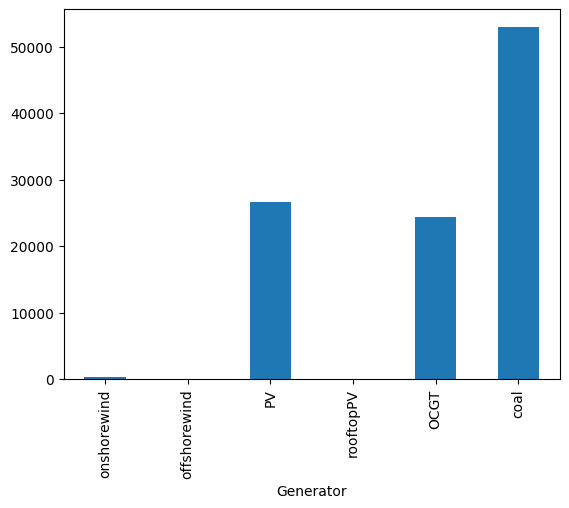

In [34]:
generators = network.generators.p_nom_opt # in MW
generators.plot.bar()